In this section you will do a practical application of GPU-accelerated data analysis using the RAPIDS
suite of libraries. The focus will be on leveraging the New York City Taxi Trip Duration dataset from
Kaggle, applying Gradient Boosting Machine (GBM) models for predictive analysis, with a particular
emphasis on comparing the speed and efficiency of GPU-accelerated computations with traditional CPUbased methods 

1. Comparative Data Processing
(a)  Perform data loading and preprocessing tasks first using pandas (CPU) and then replicate the
same tasks using cuDF (GPU). Document the time taken for each operation in both scenarios.
(b)  Conduct basic exploratory data analysis (EDA) with both CPU-based tools (e.g., matplotlib)
and GPU-accelerated tools, noting any differences in performance and responsiveness.
2. Feature Engineering and Selection
(a) Engage in feature engineering, creating new variables that could aid in predicting trip durations. Compare the execution time for these operations on CPU vs. GPU.
(b) Select relevant features for the model based on their correlation with the target variable,
assessing the speed of these operations on CPU and GPU.
3. Model Training and Evaluation
(a) Train a Gradient Boosting Machine (GBM) model on the dataset using scikit-learn (CPU)
and cuML (GPU). Record and compare the training times.
(b) Evaluate the accuracy of both models and document the time taken for predictions on the
test set using CPU and GPU.
4. Performance Analysis
(a) Compile and compare the execution times for tasks performed on CPU vs. GPU, creating a
detailed analysis of the observed performance differences.
(b) Reflect on the implications of these findings for data science workflows, particularly in terms
of efficiency and scalability.

# (a) Perform data loading and preprocessing tasks first using pandas (CPU) and then replicate the same tasks using cuDF (GPU). Document the time taken for each operation in both scenarios.

In [ ]:
#!pip install pandas==1.5.3
#!pip install matplotlib
#!pip install osmnx

In [ ]:
# !pip install \
#     --extra-index-url=https://pypi.nvidia.com \
#     cudf-cu12==24.2.* dask-cudf-cu12==24.2.* cuml-cu12==24.2.* \
#     cugraph-cu12==24.2.* cuspatial-cu12==24.2.* cuproj-cu12==24.2.* \
#     cuxfilter-cu12==24.2.* cucim-cu12==24.2.* pylibraft-cu12==24.2.* \
#     raft-dask-cu12==24.2.*

In [66]:
# Importing necessary libraries
import pandas as pd
import cudf
import cupy as cp

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import haversine as hs   
from haversine import Unit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import osmnx as ox
from sklearn.metrics import mean_squared_error, r2_score


## Loading the Datasts

In [3]:
# create a dataframe to hold CPU Metrics
cpu_metrics = pd.DataFrame(columns=['Task', 'start_time', 'end_time', 'time_taken'])

# create a dataframe to hold GPU Metrics
gpu_metrics = pd.DataFrame(columns=['Task', 'start_time', 'end_time', 'time_taken'])

In [6]:
# Load the data using cuDF
start_time_gpu = time.time()
sample_submission_gpu = cudf.read_csv('/kaggle/input/taxi-datasets/sample_submission.csv')
test_gpu = cudf.read_csv('/kaggle/input/taxi-datasets/test.csv')
train_gpu = cudf.read_csv('/kaggle/input/taxi-datasets/train.csv')
end_time_gpu = time.time()

In [7]:
# Load the data using pandas
start_time_cpu = time.time()
sample_submission_cpu = pd.read_csv('/kaggle/input/taxi-datasets/sample_submission.csv')
test_cpu = pd.read_csv('/kaggle/input/taxi-datasets/test.csv')
train_cpu = pd.read_csv('/kaggle/input/taxi-datasets/train.csv')
end_time_cpu = time.time()

In [8]:
# Display the time taken for data loading using pandas
print("Time taken for data loading using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for data loading using cuDF
print("Time taken for data loading using GUP: ", end_time_gpu - start_time_gpu)

Time taken for data loading using pandas:  6.013879776000977
Time taken for data loading using GUP:  0.23942947387695312


In [9]:
# Add the metrics to the dataframe
cpu_metrics.loc[0] = ['Data Loading', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[0] = ['Data Loading', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

In [10]:
sample_submission_cpu.head(5)

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [11]:
test_cpu.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [12]:
train_cpu.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## Data Preprocessing


In [13]:
# Data Preprocessing using cuDF
time_start_gpu = time.time()
# drop rows with missing values
train_gpu.dropna(inplace=True)
test_gpu.dropna(inplace=True)

# drop records with duplicated IDs
train_gpu.drop_duplicates(subset='id', inplace=True)

# convert the 'pickup_datetime' and 'dropoff_datetime' columns to datetime format
train_gpu['pickup_datetime'] = cudf.to_datetime(train_gpu['pickup_datetime'])

# drop the 'dropoff_datetime' column since it is not available in the test set and is not needed for prediction
# the trip duration is calculated as the difference between the 'dropoff_datetime' and 'pickup_datetime'
train_gpu.drop('dropoff_datetime', axis=1, inplace=True)

test_gpu['pickup_datetime'] = cudf.to_datetime(test_gpu['pickup_datetime'])

# create new columns for the pickup month, day of the week, and hour of the day
train_gpu['pickup_month'] = train_gpu['pickup_datetime'].dt.month
train_gpu['pickup_day'] = train_gpu['pickup_datetime'].dt.dayofweek
train_gpu['pickup_hour'] = train_gpu['pickup_datetime'].dt.hour

test_gpu['pickup_month'] = test_gpu['pickup_datetime'].dt.month
test_gpu['pickup_day'] = test_gpu['pickup_datetime'].dt.dayofweek
test_gpu['pickup_hour'] = test_gpu['pickup_datetime'].dt.hour

# drop the store_and_fwd_flag column 
train_gpu.drop('store_and_fwd_flag', axis=1, inplace=True)

#  drop the 'pickup_datetime' column since we have extracted the month, day, and hour
train_gpu.drop('pickup_datetime', axis=1, inplace=True)
test_gpu.drop('pickup_datetime', axis=1, inplace=True)

# drop the 'id' column since it is not needed for prediction
train_gpu.drop('id', axis=1, inplace=True)
test_gpu.drop('id', axis=1, inplace=True)

end_time_gpu = time.time()

In [14]:
# Data Preprocessing using pandas
time_start_cpu = time.time()
# drop rows with missing values
train_cpu.dropna(inplace=True)
test_cpu.dropna(inplace=True)

# drop records with duplicated IDs
train_cpu.drop_duplicates(subset='id', inplace=True)

# convert the 'pickup_datetime' and 'dropoff_datetime' columns to datetime format
train_cpu['pickup_datetime'] = pd.to_datetime(train_cpu['pickup_datetime'])

# drop the 'dropoff_datetime' column since it is not available in the test set and is not needed for prediction
# the trip duration is calculated as the difference between the 'dropoff_datetime' and 'pickup_datetime'
train_cpu.drop('dropoff_datetime', axis=1, inplace=True)

test_cpu['pickup_datetime'] = pd.to_datetime(test_cpu['pickup_datetime'])

# create new columns for the pickup month, day of the week, and hour of the day
train_cpu['pickup_month'] = train_cpu['pickup_datetime'].dt.month
train_cpu['pickup_day'] = train_cpu['pickup_datetime'].dt.dayofweek
train_cpu['pickup_hour'] = train_cpu['pickup_datetime'].dt.hour

test_cpu['pickup_month'] = test_cpu['pickup_datetime'].dt.month
test_cpu['pickup_day'] = test_cpu['pickup_datetime'].dt.dayofweek
test_cpu['pickup_hour'] = test_cpu['pickup_datetime'].dt.hour

# drop the store_and_fwd_flag column
train_cpu.drop('store_and_fwd_flag', axis=1, inplace=True)

# drop the 'pickup_datetime' column since we have extracted the month, day, and hour
train_cpu.drop('pickup_datetime', axis=1, inplace=True)
test_cpu.drop('pickup_datetime', axis=1, inplace=True)

# drop the 'id' column since it is not needed for prediction
train_cpu.drop('id', axis=1, inplace=True)
test_cpu.drop('id', axis=1, inplace=True)

end_time_cpu = time.time()

In [15]:
# Display the time taken for data preprocessing using pandas
print("Time taken for data preprocessing using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for data preprocessing using cuDF
print("Time taken for data preprocessing using GUP: ", end_time_gpu - time_start_gpu)

Time taken for data preprocessing using pandas:  2.5315401554107666
Time taken for data preprocessing using GUP:  0.15128135681152344


In [16]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Data Preprocessing', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Data Preprocessing', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [17]:
# make the trip duration the last column in the train dataset
train_gpu = train_gpu[[col for col in train_gpu.columns if col != 'trip_duration'] + ['trip_duration']]
train_cpu = train_cpu[[col for col in train_cpu.columns if col != 'trip_duration'] + ['trip_duration']]

In [18]:
train_cpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day,pickup_hour,trip_duration
0,2,1,-73.982155,40.767937,-73.964630,40.765602,3,0,17,455
1,1,1,-73.980415,40.738564,-73.999481,40.731152,6,6,0,663
2,2,1,-73.979027,40.763939,-74.005333,40.710087,1,1,11,2124
3,2,1,-74.010040,40.719971,-74.012268,40.706718,4,2,19,429
4,2,1,-73.973053,40.793209,-73.972923,40.782520,3,5,13,435


In [19]:
test_cpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_day,pickup_hour
0,1,1,-73.988129,40.732029,-73.990173,40.756680,N,6,3,23
1,1,1,-73.964203,40.679993,-73.959808,40.655403,N,6,3,23
2,1,1,-73.997437,40.737583,-73.986160,40.729523,N,6,3,23
3,2,1,-73.956070,40.771900,-73.986427,40.730469,N,6,3,23
4,1,1,-73.970215,40.761475,-73.961510,40.755890,N,6,3,23


In [20]:
train_gpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day,pickup_hour,trip_duration
0,2,1,-73.982155,40.767937,-73.964630,40.765602,3,0,17,455
1,1,1,-73.980415,40.738564,-73.999481,40.731152,6,6,0,663
2,2,1,-73.979027,40.763939,-74.005333,40.710087,1,1,11,2124
3,2,1,-74.010040,40.719971,-74.012268,40.706718,4,2,19,429
4,2,1,-73.973053,40.793209,-73.972923,40.782520,3,5,13,435


In [21]:
test_gpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_day,pickup_hour
0,1,1,-73.988129,40.732029,-73.990173,40.756680,N,6,3,23
1,1,1,-73.964203,40.679993,-73.959808,40.655403,N,6,3,23
2,1,1,-73.997437,40.737583,-73.986160,40.729523,N,6,3,23
3,2,1,-73.956070,40.771900,-73.986427,40.730469,N,6,3,23
4,1,1,-73.970215,40.761475,-73.961510,40.755890,N,6,3,23


## Outlier Analysis

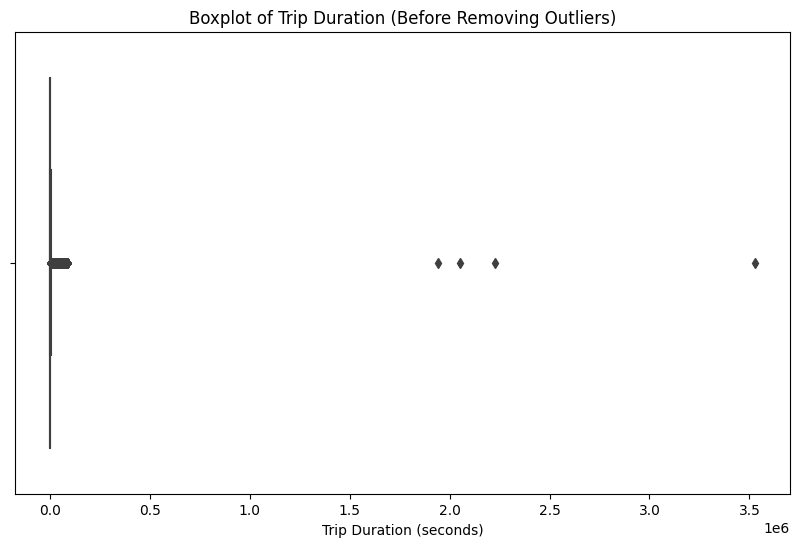


Interquartile Range (IQR): 678.0
Lower Bound: -620.0
Upper Bound: 2092.0
Number of Outliers: 74220 



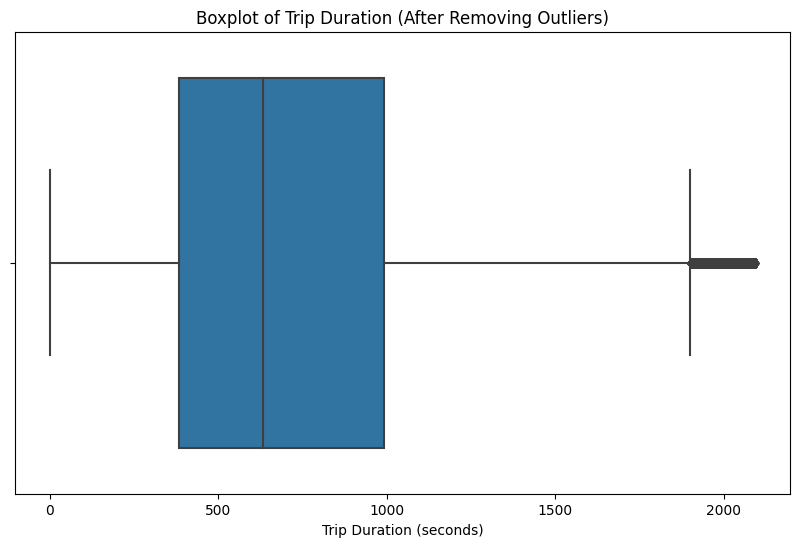

In [22]:
# using gpu
# plot boxplot for trip duration to identify outliers
# Convert GPU DataFrame to NumPy array
start_time_gpu = time.time()

train_gpu_numpy = train_gpu['trip_duration'].to_numpy()

# Plot boxplot for trip duration
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_gpu_numpy)
plt.title('Boxplot of Trip Duration (Before Removing Outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

# Calculate the interquartile range
Q1 = np.percentile(train_gpu_numpy, 25)
Q3 = np.percentile(train_gpu_numpy, 75)

IQR = Q3 - Q1

print('\nInterquartile Range (IQR):', IQR)

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

# Identify outliers
outliers = train_gpu_numpy[(train_gpu_numpy < lower_bound) | (train_gpu_numpy > upper_bound)]
print('Number of Outliers:', len(outliers), "\n")

# Remove outliers
train_gpu = train_gpu[(train_gpu['trip_duration'] >= lower_bound) & (train_gpu['trip_duration'] <= upper_bound)]

train_gpu_numpy2 = train_gpu['trip_duration'].to_numpy()
# boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_gpu_numpy2)
plt.title('Boxplot of Trip Duration (After Removing Outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

end_time_gpu = time.time()

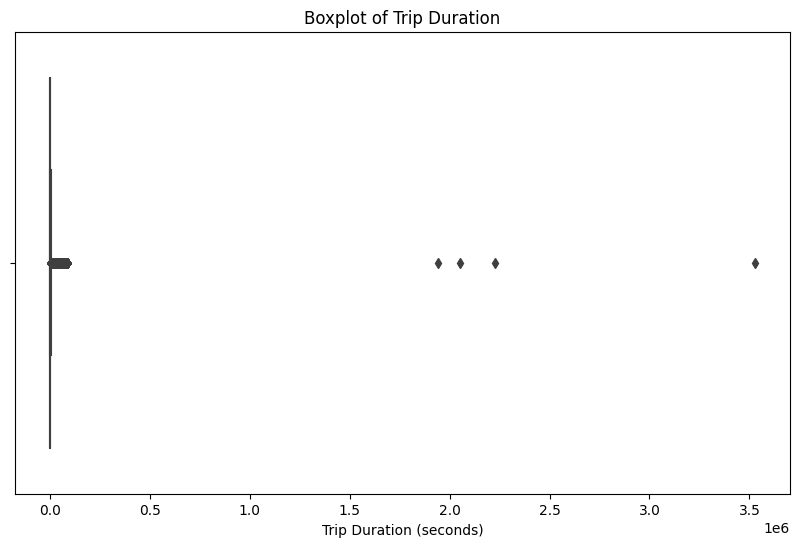


Interquartile Range (IQR): 678.0
Lower Bound: -620.0
Upper Bound: 2092.0
Number of Outliers: 74220 



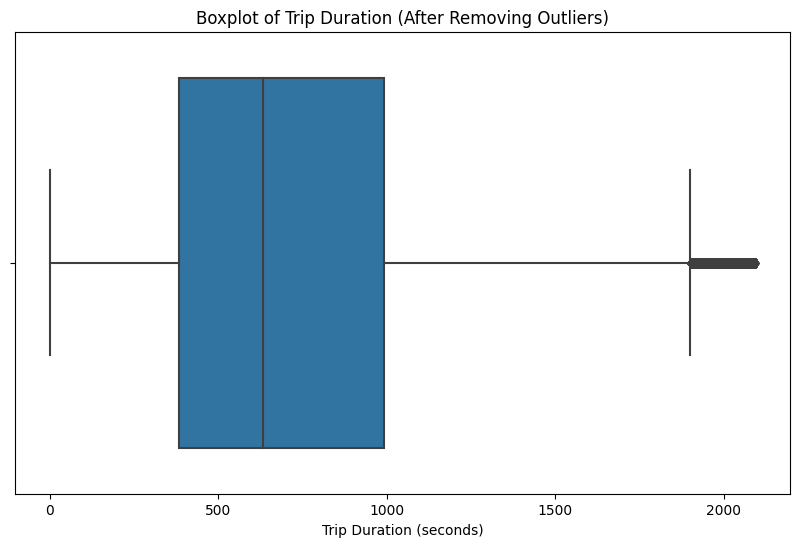

In [23]:
# using cpu
# plot boxplot for trip duration to identify outliers
# Plot boxplot for trip duration
start_time_cpu = time.time()

plt.figure(figsize=(10, 6))
sns.boxplot(x=train_cpu['trip_duration'])
plt.title('Boxplot of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.show()

# Calculate the interquartile range
Q1 = train_cpu['trip_duration'].quantile(0.25)
Q3 = train_cpu['trip_duration'].quantile(0.75)

IQR = Q3 - Q1

print('\nInterquartile Range (IQR):', IQR)

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

# Identify outliers
outliers = train_cpu[(train_cpu['trip_duration'] < lower_bound) | (train_cpu['trip_duration'] > upper_bound)]
print('Number of Outliers:', len(outliers), "\n")

# Remove outliers
train_cpu = train_cpu[(train_cpu['trip_duration'] >= lower_bound) & (train_cpu['trip_duration'] <= upper_bound)]

# boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_cpu['trip_duration'])
plt.title('Boxplot of Trip Duration (After Removing Outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

end_time_cpu = time.time()

In [24]:
# Display the time taken for outlier analysis using pandas
print("Time taken for outlier analysis using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for outlier analysis using cuDF
print("Time taken for outlier analysis using GUP: ", end_time_gpu - start_time_gpu)

Time taken for outlier analysis using pandas:  0.8221678733825684
Time taken for outlier analysis using GUP:  0.6518394947052002


In [25]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Outlier Analysis', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Outlier Analysis', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# (b) Conduct basic exploratory data analysis (EDA) with both CPU-based tools (e.g., matplotlib) and GPU-accelerated tools, noting any differences in performance and responsiveness.


In [26]:
data_pandas = train_gpu.to_pandas()
trip_duration_pandas = train_gpu['trip_duration'].to_pandas()

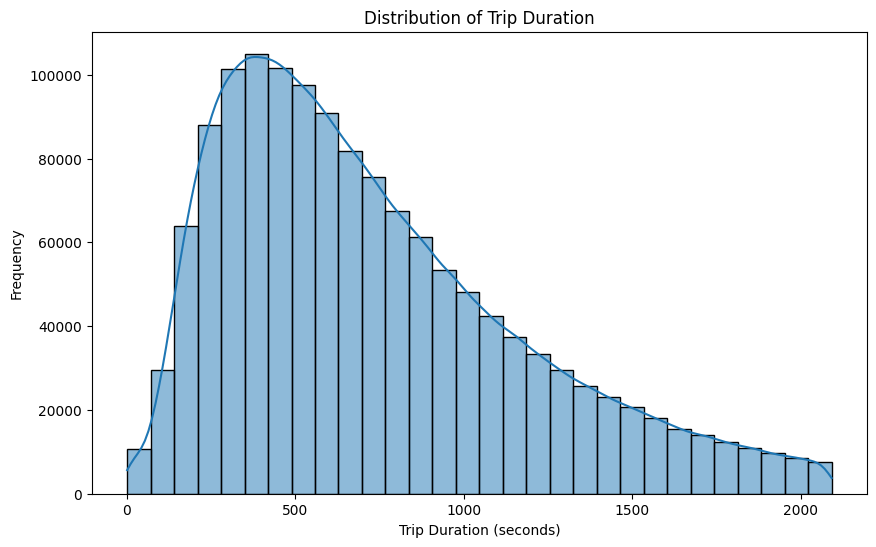

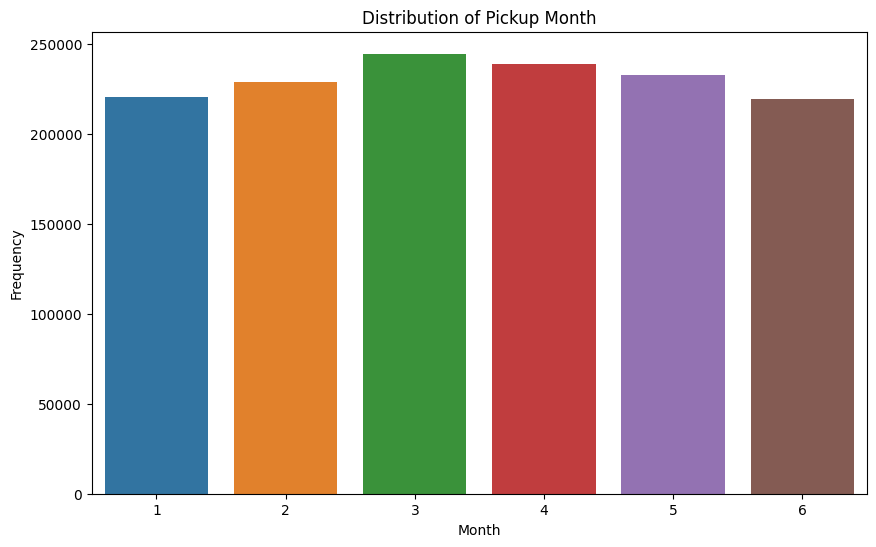

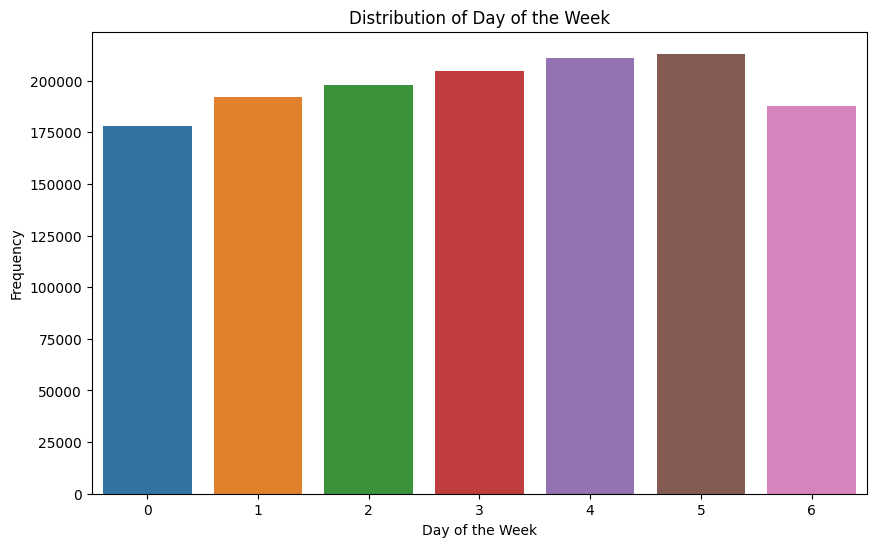

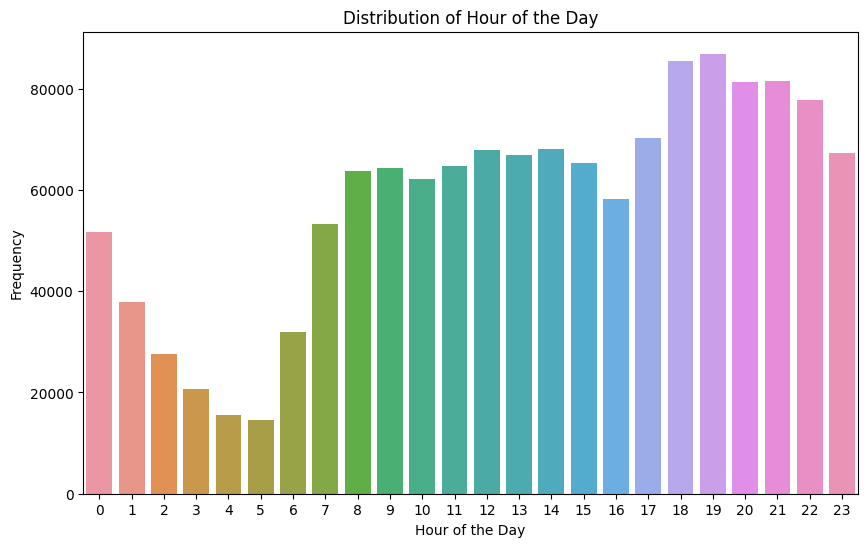

In [27]:
# EDA using GPU
# use seaborn to plot the distribution of the trip duration

start_time_gpu = time.time()

plt.figure(figsize=(10, 6))
sns.histplot(trip_duration_pandas, bins=30, kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# plot the distribution of the pickup month
plt.figure(figsize=(10, 6))
sns.countplot(x='pickup_month', data=data_pandas)
plt.title('Distribution of Pickup Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

# plot the distribution of the day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='pickup_day', data=data_pandas)
plt.title('Distribution of Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.show()

# plot the distribution of the hour of the day
plt.figure(figsize=(10, 6))
sns.countplot(x='pickup_hour', data=data_pandas)
plt.title('Distribution of Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.show()

end_time_gpu = time.time()


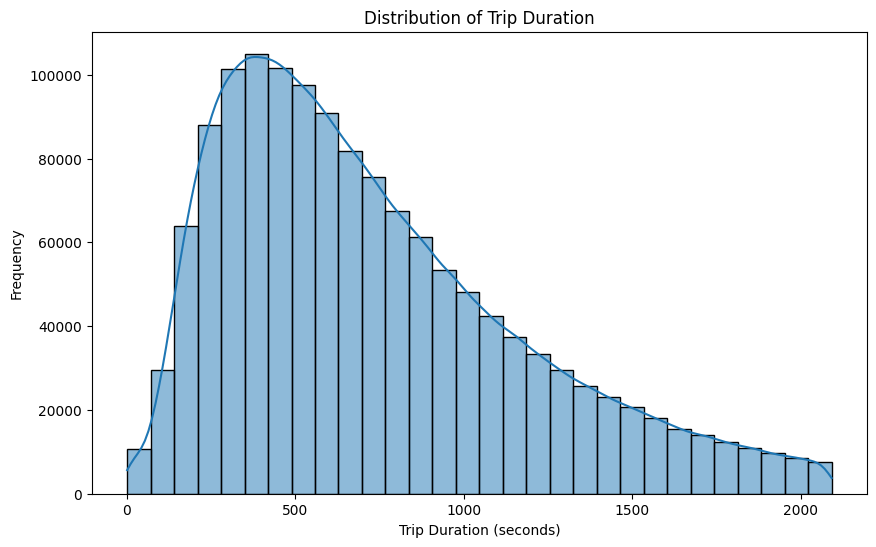

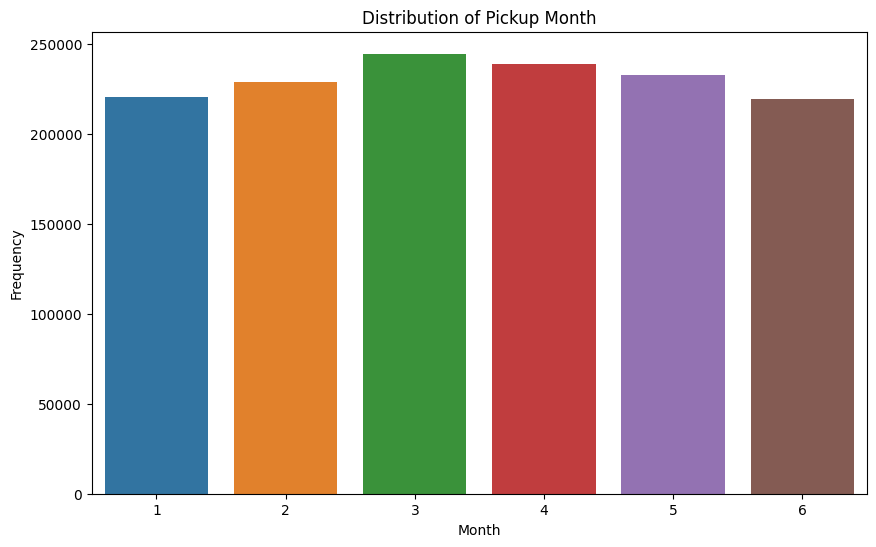

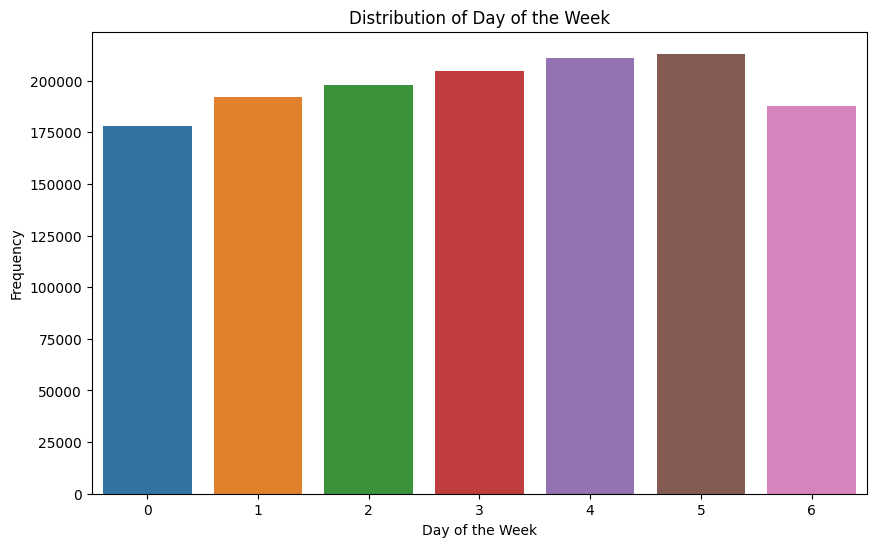

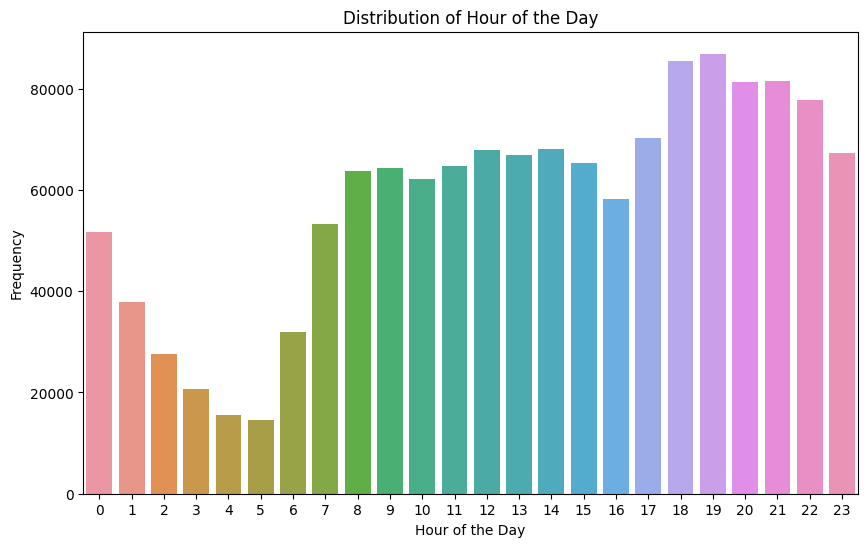

In [28]:
# EDA using CPU
# use seaborn to plot the distribution of the trip duration

start_time_cpu = time.time()

plt.figure(figsize=(10, 6))
sns.histplot(train_cpu['trip_duration'], bins=30, kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# plot the distribution of the pickup month
plt.figure(figsize=(10, 6))
sns.countplot(x='pickup_month', data=train_cpu)
plt.title('Distribution of Pickup Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

# plot the distribution of the day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='pickup_day', data=train_cpu)
plt.title('Distribution of Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.show()

# plot the distribution of the hour of the day
plt.figure(figsize=(10, 6))
sns.countplot(x='pickup_hour', data=train_cpu)
plt.title('Distribution of Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.show()

end_time_cpu = time.time()

In [29]:
# Display the time taken for EDA using pandas
print("Time taken for EDA using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for EDA using cuDF
print("Time taken for EDA using GUP: ", end_time_gpu - start_time_gpu)

Time taken for EDA using pandas:  7.426305055618286
Time taken for EDA using GUP:  7.357328414916992


In [30]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['EDA', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['EDA', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# 2. Feature Engineering and Selection


# (a) Engage in feature engineering, creating new variables that could aid in predicting trip durations. Compare the execution time for these operations on CPU vs. GPU.


In [36]:
# Calculate the haversine distance between pickup and dropoff coordinates
def calculate_distance(row):
    pickup_coords = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff_coords = (row['dropoff_latitude'], row['dropoff_longitude'])
    return hs.haversine(pickup_coords, dropoff_coords, unit=Unit.KILOMETERS)

def calculate_direction(row):
    return ox.bearing.calculate_bearing(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])

In [37]:
training_gpu_pandas = train_gpu.to_pandas()
test_gpu_pandas = test_gpu.to_pandas()

In [38]:
# Feature Engineering using cuDF
# create a new column for the distance of the trip
# create a new column for the distance and direction of the trip
time_start_gpu = time.time()

train_gpu['distance'] = training_gpu_pandas.apply(calculate_distance, axis=1)
test_gpu['distance'] = test_gpu_pandas.apply(calculate_distance, axis=1)

train_gpu['direction'] = training_gpu_pandas.apply(calculate_direction, axis=1)
test_gpu['direction'] = test_gpu_pandas.apply(calculate_direction, axis=1)

end_time_gpu = time.time()

In [39]:
# Feature Engineering using pandas 
# create a new column for the distance of the trip

time_start_cpu = time.time()

train_cpu['distance'] = train_cpu.apply(calculate_distance, axis=1)
test_cpu['distance'] = test_cpu.apply(calculate_distance, axis=1)

train_cpu['direction'] = train_cpu.apply(calculate_direction, axis=1)
test_cpu['direction'] = test_cpu.apply(calculate_direction, axis=1)

end_time_cpu = time.time()

In [40]:
# Display the time taken for feature engineering using pandas
print("Time taken for feature engineering using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for feature engineering using cuDF
print("Time taken for feature engineering using GUP: ", end_time_gpu - time_start_gpu)

Time taken for feature engineering using pandas:  147.57773065567017
Time taken for feature engineering using GUP:  148.41656875610352


In [41]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Feature Engineering', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Feature Engineering', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [42]:
train_gpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day,pickup_hour,trip_duration,distance,direction
0,2,1,-73.982155,40.767937,-73.964630,40.765602,3,0,17,455,1.498523,99.970196
1,1,1,-73.980415,40.738564,-73.999481,40.731152,6,6,0,663,1.805510,242.846232
3,2,1,-74.010040,40.719971,-74.012268,40.706718,4,2,19,429,1.485500,187.262300
4,2,1,-73.973053,40.793209,-73.972923,40.782520,3,5,13,435,1.188590,179.473585
5,2,6,-73.982857,40.742195,-73.992081,40.749184,1,5,22,443,1.098944,315.004404


In [43]:
test_gpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_day,pickup_hour,distance,direction
0,1,1,-73.988129,40.732029,-73.990173,40.756680,N,6,3,23,2.746430,356.404776
1,1,1,-73.964203,40.679993,-73.959808,40.655403,N,6,3,23,2.759243,172.278835
2,1,1,-73.997437,40.737583,-73.986160,40.729523,N,6,3,23,1.306157,133.326248
3,2,1,-73.956070,40.771900,-73.986427,40.730469,N,6,3,23,5.269095,209.043167
4,1,1,-73.970215,40.761475,-73.961510,40.755890,N,6,3,23,0.960843,130.260381


In [44]:
train_cpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day,pickup_hour,trip_duration,distance,direction
0,2,1,-73.982155,40.767937,-73.964630,40.765602,3,0,17,455,1.498523,99.970196
1,1,1,-73.980415,40.738564,-73.999481,40.731152,6,6,0,663,1.805510,242.846232
3,2,1,-74.010040,40.719971,-74.012268,40.706718,4,2,19,429,1.485500,187.262300
4,2,1,-73.973053,40.793209,-73.972923,40.782520,3,5,13,435,1.188590,179.473585
5,2,6,-73.982857,40.742195,-73.992081,40.749184,1,5,22,443,1.098944,315.004404


In [45]:
test_cpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_day,pickup_hour,distance,direction
0,1,1,-73.988129,40.732029,-73.990173,40.756680,N,6,3,23,2.746430,356.404776
1,1,1,-73.964203,40.679993,-73.959808,40.655403,N,6,3,23,2.759243,172.278835
2,1,1,-73.997437,40.737583,-73.986160,40.729523,N,6,3,23,1.306157,133.326248
3,2,1,-73.956070,40.771900,-73.986427,40.730469,N,6,3,23,5.269095,209.043167
4,1,1,-73.970215,40.761475,-73.961510,40.755890,N,6,3,23,0.960843,130.260381


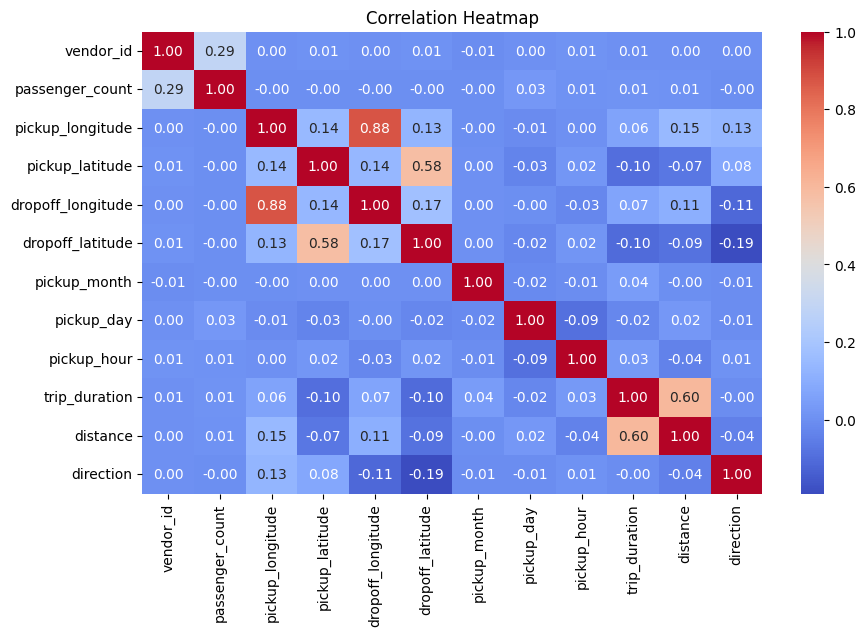

In [48]:
# Feature Selection using cuDF
# calculate the correlation between the features and the target variable trip_duration
time_start_gpu = time.time()

correlation_gpu = train_gpu.to_pandas().corr()['trip_duration']
# print corelation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train_gpu.to_pandas().corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

end_time_gpu = time.time()

In [49]:
correlation_gpu

vendor_id            0.005007
passenger_count      0.011911
pickup_longitude     0.062341
pickup_latitude     -0.095930
dropoff_longitude    0.066463
dropoff_latitude    -0.103299
pickup_month         0.039426
pickup_day          -0.023127
pickup_hour          0.028536
trip_duration        1.000000
distance             0.601087
direction           -0.004814
Name: trip_duration, dtype: float64

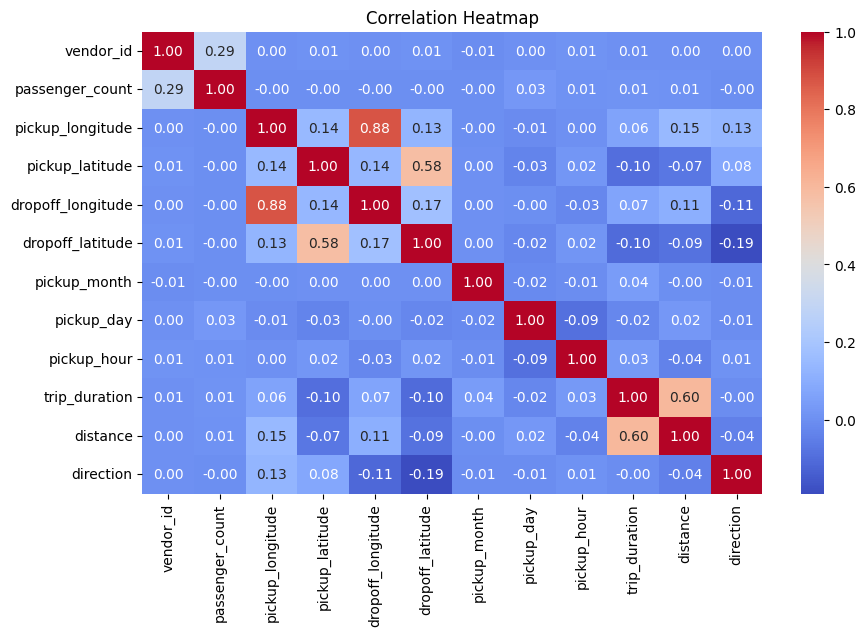

In [50]:
# Feature Selection using pandas
# calculate the correlation between the features and the target variable trip_duration
time_start_cpu = time.time()

correlation_cpu = train_cpu.corr()['trip_duration']

# print corelation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train_cpu.corr(), annot=True, cmap='coolwarm', fmt=".2f")   
plt.title('Correlation Heatmap')
plt.show()

end_time_cpu = time.time()

In [51]:
correlation_cpu

vendor_id            0.005007
passenger_count      0.011911
pickup_longitude     0.062341
pickup_latitude     -0.095930
dropoff_longitude    0.066463
dropoff_latitude    -0.103299
pickup_month         0.039426
pickup_day          -0.023127
pickup_hour          0.028536
trip_duration        1.000000
distance             0.601087
direction           -0.004814
Name: trip_duration, dtype: float64

The choosen features based on the correlation values are:
- distance
- dropoff_longitude
- dropoff_latitude
- pickup_longitude
- pickup_latitude
- pickup_hour   
- pickup_month
- pickup_day

In [52]:
# Display the time taken for Correlation Analysis using pandas
print("Time taken for Correlation Analysis using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for Correlation Analysis using cuDF
print("Time taken for Correlation Analysis using GUP: ", end_time_gpu - time_start_gpu)

Time taken for Correlation Analysis using pandas:  2.076143741607666
Time taken for Correlation Analysis using GUP:  2.051762342453003


In [53]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Correlation Analysis', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Correlation Analysis', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [54]:
# create a new dataframe with only the selected features for both the training and test sets using cuDF
time_start_gpu = time.time()

train_gpu_feature = train_gpu[['distance', 'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_month', 'pickup_day', 'trip_duration']]
test_gpu_feature = test_gpu[['distance', 'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_month', 'pickup_day']]

end_time_gpu = time.time()

In [55]:
# create a new dataframe with only the selected features for both the training and test sets using pandas

time_start_cpu = time.time()

train_cpu_feature = train_cpu[['distance', 'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_month', 'pickup_day', 'trip_duration']]
test_cpu_feature = test_cpu[['distance', 'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_month', 'pickup_day']]

end_time_cpu = time.time()

In [56]:
# Display the time taken for feature selection using pandas
print("Time taken for feature selection using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for feature selection using cuDF
print("Time taken for feature selection using GUP: ", end_time_gpu - time_start_gpu)

Time taken for feature selection using pandas:  0.03840947151184082
Time taken for feature selection using GUP:  0.0012753009796142578


In [57]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Feature Selection', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Feature Selection', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [58]:
cpu_metrics

,Task,start_time,end_time,time_taken
0,Data Loading,1.713629e+09,1.713629e+09,6.013880
1,Data Preprocessing,1.713629e+09,1.713629e+09,2.531540
2,Outlier Analysis,1.713629e+09,1.713629e+09,0.822168
3,EDA,1.713629e+09,1.713629e+09,7.426305
4,Feature Engineering,1.713630e+09,1.713630e+09,147.577731
5,Correlation Analysis,1.713630e+09,1.713630e+09,2.076144
6,Feature Selection,1.713631e+09,1.713631e+09,0.038409


In [59]:
gpu_metrics

,Task,start_time,end_time,time_taken
0,Data Loading,1.713629e+09,1.713629e+09,0.239429
1,Data Preprocessing,1.713629e+09,1.713629e+09,0.151281
2,Outlier Analysis,1.713629e+09,1.713629e+09,0.651839
3,EDA,1.713629e+09,1.713629e+09,7.357328
4,Feature Engineering,1.713630e+09,1.713630e+09,148.416569
5,Correlation Analysis,1.713630e+09,1.713630e+09,2.051762
6,Feature Selection,1.713631e+09,1.713631e+09,0.001275


# 3. Model Training and Evaluation


# (a) Train a Gradient Boosting Machine (GBM) model on the dataset using scikit-learn (CPU) and cuML (GPU). Record and compare the training times.


In [60]:
# Model Training using cuML

inputs_gpu = train_gpu_feature.drop('trip_duration', axis=1)
targer_gpu = train_gpu_feature['trip_duration']

X_gpu = inputs_gpu.values
y_gpu = targer_gpu.values

# Split the data into training and testing sets
X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu = train_test_split(X_gpu, y_gpu, test_size=0.2, random_state=42)

# Train the Gradient Boosting Machine model using cuML
start_time_gpu = time.time()

gbm_gpu = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
gbm_gpu.fit(X_train_gpu, y_train_gpu)
#y_pred_gpu = gbm_gpu.predict(X_train_gpu_reshaped)

end_time_gpu = time.time()

In [61]:
# Model Training using scikit-learn

inputs_cpu = train_cpu_feature.drop('trip_duration', axis=1)
targer_cpu = train_cpu_feature['trip_duration']

X_cpu = inputs_cpu.values
y_cpu = targer_cpu.values

# Split the data into training and testing sets
X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(X_cpu, y_cpu, test_size=0.2, random_state=42)

# Train the Gradient Boosting Machine model using scikit-learn

start_time_cpu = time.time()

gbm_cpu = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
gbm_cpu.fit(X_train_cpu, y_train_cpu)
#y_pred_cpu = gbm_cpu.predict(X_train_cpu)

end_time_cpu = time.time()

In [62]:
# Display the time taken for model training using scikit-learn
print("Time taken for model training using scikit-learn: ", end_time_cpu - start_time_cpu)
# Display the time taken for model training using cuML
print("Time taken for model training using cuML: ", end_time_gpu - start_time_gpu)

Time taken for model training using scikit-learn:  409.93502259254456
Time taken for model training using cuML:  3.888578176498413


In [63]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Model Training', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Model Training', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# (b) Evaluate the accuracy of both models and document the time taken for predictions on the test set using CPU and GPU.


In [67]:
# Model Evaluation using xgboost
# Evaluate the model on the test set

start_time_gpu = time.time()

# evaluate the model on the test data
predictions_gpu = gbm_gpu.predict(X_test_gpu)

# output the first 5 predictions
print('Predictions:', predictions_gpu[:5])

# Model Evaluation using xgboost
# Evaluate the model on the test set

start_time_gpu = time.time()

# Convert Cupy arrays to NumPy arrays
y_test_numpy = cp.asnumpy(y_test_gpu)
predictions_numpy = cp.asnumpy(predictions_gpu)

# Calculate the mean squared error
mean_squared_error_gpu = mean_squared_error(y_test_numpy, predictions_numpy)
print('Mean Squared Error (GPU):', mean_squared_error_gpu)

# calculate the R-squared value
r_squared_gpu = r2_score(y_test_numpy, predictions_numpy)
print('R-squared (GPU):', r_squared_gpu)

end_time_gpu = time.time()


Predictions: [ 190.87059 1030.331    729.8232   875.33295  962.9413 ]
Mean Squared Error (GPU): 55797.90466748219
R-squared (GPU): 0.7219170710647425


In [68]:
# Model Evaluation using scikit-learn
# Evaluate the model on the test set

# evaluate the model on the test data

predictions_cpu = gbm_cpu.predict(X_test_cpu)

# output the first 5 predictions
print('Predictions:', predictions_cpu[:5])

# Model Evaluation using scikit-learn
# Evaluate the model on the test set

start_time_cpu = time.time()

# Calculate the mean squared error
mean_squared_error_cpu = mean_squared_error(y_test_cpu, predictions_cpu)
print('Mean Squared Error (CPU):', mean_squared_error_cpu)

# calculate the R-squared value
r_squared_cpu = r2_score(y_test_cpu, predictions_cpu)
print('R-squared (CPU):', r_squared_cpu)

end_time_cpu = time.time()

Predictions: [ 204.56622236 1038.65746147  748.02442271  903.1366256   932.84923203]
Mean Squared Error (CPU): 55857.445238140965
R-squared (CPU): 0.7216203356160201


In [69]:
# Display the time taken for model evaluation using scikit-learn
print("Time taken for model evaluation using scikit-learn: ", end_time_cpu - start_time_cpu)
# Display the time taken for model evaluation using cuML
print("Time taken for model evaluation using cuML: ", end_time_gpu - start_time_gpu)

Time taken for model evaluation using scikit-learn:  0.0042877197265625
Time taken for model evaluation using cuML:  0.0058252811431884766


In [70]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Model Evaluation', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Model Evaluation', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

In [71]:
cpu_metrics

,Task,start_time,end_time,time_taken
0,Data Loading,1.713629e+09,1.713629e+09,6.013880
1,Data Preprocessing,1.713629e+09,1.713629e+09,2.531540
2,Outlier Analysis,1.713629e+09,1.713629e+09,0.822168
3,EDA,1.713629e+09,1.713629e+09,7.426305
4,Feature Engineering,1.713630e+09,1.713630e+09,147.577731
5,Correlation Analysis,1.713630e+09,1.713630e+09,2.076144
6,Feature Selection,1.713631e+09,1.713631e+09,0.038409
7,Model Training,1.713631e+09,1.713631e+09,409.935023
8,Model Evaluation,1.713632e+09,1.713632e+09,0.004288


In [72]:
gpu_metrics

,Task,start_time,end_time,time_taken
0,Data Loading,1.713629e+09,1.713629e+09,0.239429
1,Data Preprocessing,1.713629e+09,1.713629e+09,0.151281
2,Outlier Analysis,1.713629e+09,1.713629e+09,0.651839
3,EDA,1.713629e+09,1.713629e+09,7.357328
4,Feature Engineering,1.713630e+09,1.713630e+09,148.416569
5,Correlation Analysis,1.713630e+09,1.713630e+09,2.051762
6,Feature Selection,1.713631e+09,1.713631e+09,0.001275
7,Model Training,1.713631e+09,1.713631e+09,3.888578
8,Model Evaluation,1.713632e+09,1.713632e+09,0.005825
